# 数据预处理方案

根据我们详细的EDA分析结果，我为这个心理健康数据集设计了一个全面的预处理方案。以下是基于探索性分析发现的最终预处理步骤：

## 1. 缺失值处理
- EDA显示数据集没有缺失值，所以跳过此步骤

## 2. 类别变量处理

### 2.1 性别变量(gender)
- **问题**：非二元性别(5.2%)和不愿透露(4.7%)占比低于10%
- **方案**：将"Non-binary"和"Prefer not to say"合并为"Other"类别
- **编码**：使用独热编码，生成"Female"、"Male"和"Other"三个特征列(drop='first')

### 2.2 就业状况(employment_status)
- **问题**：分布相对均衡，各类别均超过10%
- **方案**：直接编码，无需额外处理
- **编码**：使用独热编码，drop='first'策略

### 2.3 工作环境(work_environment)
- **问题**：存在分布差异，但各类别样本量充足
- **方案**：直接编码，无需额外处理
- **编码**：使用独热编码，drop='first'策略

### 2.4 精神病史(mental_health_history)
- **问题**：严重不均衡(69.7% vs 30.3%)
- **方案**：使用0/1编码，并在模型训练时使用class_weight参数平衡
- **编码**：Yes=1, No=0

### 2.5 寻求治疗(seeks_treatment)
- **问题**：中等程度不均衡(60.1% vs 39.9%)
- **方案**：使用0/1编码，并在模型训练时关注这一变量
- **编码**：Yes=1, No=0

### 2.6 特征交互生成
- 创建精神病史与寻求治疗的交互特征：mental_health_history × seeks_treatment

## 3. 数值变量处理

### 3.1 异常值处理
- EDA显示数值变量无异常值，无需处理

### 3.2 标准化
- 根据标准化需求分析，对以下变量进行标准化：
  - age (范围=47.00)
  - depression_score (范围=30.00)
  - anxiety_score (范围=21.00)
  - social_support_score (范围=100.00)
  - productivity_score (范围=57.20)
- 以下变量范围较小，可选择性标准化：
  - stress_level (范围=9.00)
  - sleep_hours (范围=7.00)
  - physical_activity_days (范围=7.00)

### 3.3 多重共线性处理
- 处理高度相关变量：depression_score与productivity_score (r=-0.94)
- 方案：保留depression_score (与目标变量相关性更强)，移除productivity_score

## 4. 目标变量编码
- mental_health_risk变量编码为：Low=0, Medium=1, High=2

## 5. 数据集划分
- 采用80%/20%的训练/测试集比例
- 使用分层抽样(stratify=y)保持各类别比例
- 设置random_state=42确保可重复性

## 6. 样本平衡处理
- 为处理目标变量可能的类别不平衡，准备在模型训练阶段使用：
  - 对于树模型：使用class_weight='balanced'
  - 对于其他模型：考虑使用SMOTE过采样技术

通过以上预处理步骤，我们将原始数据转换为适合机器学习算法的格式，同时保留数据中的关键信息。这个方案综合考虑了类别不平衡、变量相关性、标准化需求等多个因素，为后续的建模工作奠定基础。


In [8]:
# 3. 数据预处理

# 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
import joblib

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False    # 用来正常显示负号
sns.set(style="whitegrid")



In [9]:
print("=== 3. 数据预处理 ===")

# 读取原始数据
df = pd.read_csv('mental_health_dataset.csv')
print(f"原始数据维度: {df.shape}")
print(f"原始数据列: {df.columns.tolist()}")
print("\n数据前5行:")
print(df.head())

# 检查缺失值
missing_values = df.isnull().sum()
if missing_values.sum() > 0:
    print("\n存在缺失值:")
    print(missing_values[missing_values > 0])
else:
    print("\n数据集没有缺失值，无需填充")

# 1. 特征工程：合并性别少数类别
print("\n=== 1. 类别变量处理 ===")
print("原始性别分布:")
print(df['gender'].value_counts())

# 将非二元性别和不愿透露合并为"Other"
df['gender'] = df['gender'].replace(['Non-binary', 'Prefer not to say'], 'Other')
print("\n合并后性别分布:")
print(df['gender'].value_counts())

# 2. 创建特征交互项
print("\n=== 2. 创建特征交互项 ===")
# 将类别变量转换为数值以创建交互特征
df['mental_health_history_num'] = df['mental_health_history'].map({'Yes': 1, 'No': 0})
df['seeks_treatment_num'] = df['seeks_treatment'].map({'Yes': 1, 'No': 0})

# 创建交互特征
df['treatment_history_interaction'] = df['mental_health_history_num'] * df['seeks_treatment_num']
print("交互特征分布:")
print(df['treatment_history_interaction'].value_counts())

# 3. 编码类别变量
print("\n=== 3. 编码类别变量 ===")

# 准备进行独热编码的多类别变量
multi_cat_cols = ['gender', 'employment_status', 'work_environment']
binary_cat_cols = ['mental_health_history', 'seeks_treatment']

# 使用独热编码处理多类别变量
print("\n独热编码多类别变量:")
encoded_dfs = []

for col in multi_cat_cols:
    # 创建一个OneHotEncoder对象
    encoder = OneHotEncoder(drop='first', sparse=False)
    # 进行编码
    encoded = encoder.fit_transform(df[[col]])
    # 获取特征名称
    feature_names = [f"{col}_{cat}" for cat in encoder.categories_[0][1:]]
    # 创建DataFrame
    encoded_df = pd.DataFrame(encoded, columns=feature_names, index=df.index)
    encoded_dfs.append(encoded_df)
    print(f"  - {col} 编码为: {feature_names}")

# 使用0/1编码处理二元变量
print("\n二元变量编码:")
for col in binary_cat_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0})
    print(f"  - {col} 编码为: 0/1")

# 4. 处理多重共线性
print("\n=== 4. 处理多重共线性 ===")
print("移除 productivity_score (与depression_score高度相关，r=-0.94)")

# 要保留的数值列
numeric_cols = ['age', 'stress_level', 'sleep_hours', 'physical_activity_days', 
               'depression_score', 'anxiety_score', 'social_support_score']
# 移除productivity_score

# 5. 标准化数值变量
print("\n=== 5. 标准化数值变量 ===")

# 需要标准化的变量
std_cols = ['age', 'depression_score', 'anxiety_score', 'social_support_score']
optional_std_cols = ['stress_level', 'sleep_hours', 'physical_activity_days']

# 标准化前的统计信息
print("标准化前数值变量的统计信息:")
print(df[numeric_cols].describe().round(2).T[['mean', 'std', 'min', 'max']])

# 创建一个新的DataFrame以存储处理后的数据
df_processed = df.copy()

# 对需要标准化的变量进行标准化
scaler = StandardScaler()
df_processed[std_cols] = scaler.fit_transform(df[std_cols])

# 对可选标准化的变量也进行标准化（为了统一处理）
scaler_optional = StandardScaler()
df_processed[optional_std_cols] = scaler_optional.fit_transform(df[optional_std_cols])

# 标准化后的统计信息
print("\n标准化后数值变量的统计信息:")
print(df_processed[numeric_cols].describe().round(2).T[['mean', 'std', 'min', 'max']])

print("\n数据预处理完成，数据已准备就绪，可以进行建模")

=== 3. 数据预处理 ===
原始数据维度: (10000, 14)
原始数据列: ['age', 'gender', 'employment_status', 'work_environment', 'mental_health_history', 'seeks_treatment', 'stress_level', 'sleep_hours', 'physical_activity_days', 'depression_score', 'anxiety_score', 'social_support_score', 'productivity_score', 'mental_health_risk']

数据前5行:
   age      gender employment_status work_environment mental_health_history  \
0   56        Male          Employed          On-site                   Yes   
1   46      Female           Student          On-site                    No   
2   32      Female          Employed          On-site                   Yes   
3   60  Non-binary     Self-employed          On-site                    No   
4   25      Female     Self-employed          On-site                   Yes   

  seeks_treatment  stress_level  sleep_hours  physical_activity_days  \
0             Yes             6          6.2                       3   
1             Yes            10          9.0                    

In [10]:
# 6. 编码目标变量
print("\n=== 6. 编码目标变量 ===")
print("目标变量原始分布:")
print(df['mental_health_risk'].value_counts())

# 使用LabelEncoder编码目标变量
le = LabelEncoder()
# 确保编码顺序为Low, Medium, High
le.fit(['Low', 'Medium', 'High'])
df_processed['mental_health_risk'] = le.transform(df['mental_health_risk'])

print("\n目标变量编码后分布:")
print(df_processed['mental_health_risk'].value_counts())
print(f"编码映射: {dict(zip(le.classes_, le.transform(le.classes_)))}")

# 7. 构建最终特征集
print("\n=== 7. 构建最终特征集 ===")

# 合并所有编码后的特征
# 数值特征
features = df_processed[numeric_cols].copy()

# 添加二元变量
for col in binary_cat_cols:
    features[col] = df_processed[col]

# 添加交互特征
features['treatment_history_interaction'] = df_processed['treatment_history_interaction']

# 添加独热编码的特征
for encoded_df in encoded_dfs:
    features = pd.concat([features, encoded_df], axis=1)

# 检查最终特征集
print(f"最终特征数量: {features.shape[1]}")
print(f"特征列表:\n{features.columns.tolist()}")




=== 6. 编码目标变量 ===
目标变量原始分布:
Medium    5892
High      2369
Low       1739
Name: mental_health_risk, dtype: int64

目标变量编码后分布:
2    5892
0    2369
1    1739
Name: mental_health_risk, dtype: int64
编码映射: {'High': 0, 'Low': 1, 'Medium': 2}

=== 7. 构建最终特征集 ===
最终特征数量: 17
特征列表:
['age', 'stress_level', 'sleep_hours', 'physical_activity_days', 'depression_score', 'anxiety_score', 'social_support_score', 'mental_health_history', 'seeks_treatment', 'treatment_history_interaction', 'gender_Male', 'gender_Other', 'employment_status_Self-employed', 'employment_status_Student', 'employment_status_Unemployed', 'work_environment_On-site', 'work_environment_Remote']


In [11]:
# 8. 划分训练集和测试集
print("\n=== 8. 划分训练集和测试集 ===")

# 定义特征变量和目标变量
X = features
y = df_processed['mental_health_risk']

# 使用分层抽样划分数据集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"训练集大小: {X_train.shape}")
print(f"测试集大小: {X_test.shape}")

# 验证目标变量分布是否保持一致
print("\n训练集目标分布:")
print(pd.Series(y_train).value_counts(normalize=True).round(3) * 100)
print("\n测试集目标分布:")
print(pd.Series(y_test).value_counts(normalize=True).round(3) * 100)




=== 8. 划分训练集和测试集 ===
训练集大小: (8000, 17)
测试集大小: (2000, 17)

训练集目标分布:
2    58.9
0    23.7
1    17.4
Name: mental_health_risk, dtype: float64

测试集目标分布:
2    58.9
0    23.7
1    17.4
Name: mental_health_risk, dtype: float64



=== 9. 保存预处理后的数据和编码器 ===

预处理完成，数据已保存为CSV文件

=== 10. 预处理结果总结 ===
1. 原始数据样本数: 10000, 特征数: 17
2. 处理后特征数: 17
3. 移除的特征: productivity_score（与depression_score高度相关）
4. 合并的类别: 'Non-binary'和'Prefer not to say'被合并为'Other'
5. 添加的交互特征: mental_health_history × seeks_treatment
6. 标准化的变量: ['age', 'depression_score', 'anxiety_score', 'social_support_score', 'stress_level', 'sleep_hours', 'physical_activity_days']
7. 训练集样本数: 8000
8. 测试集样本数: 2000


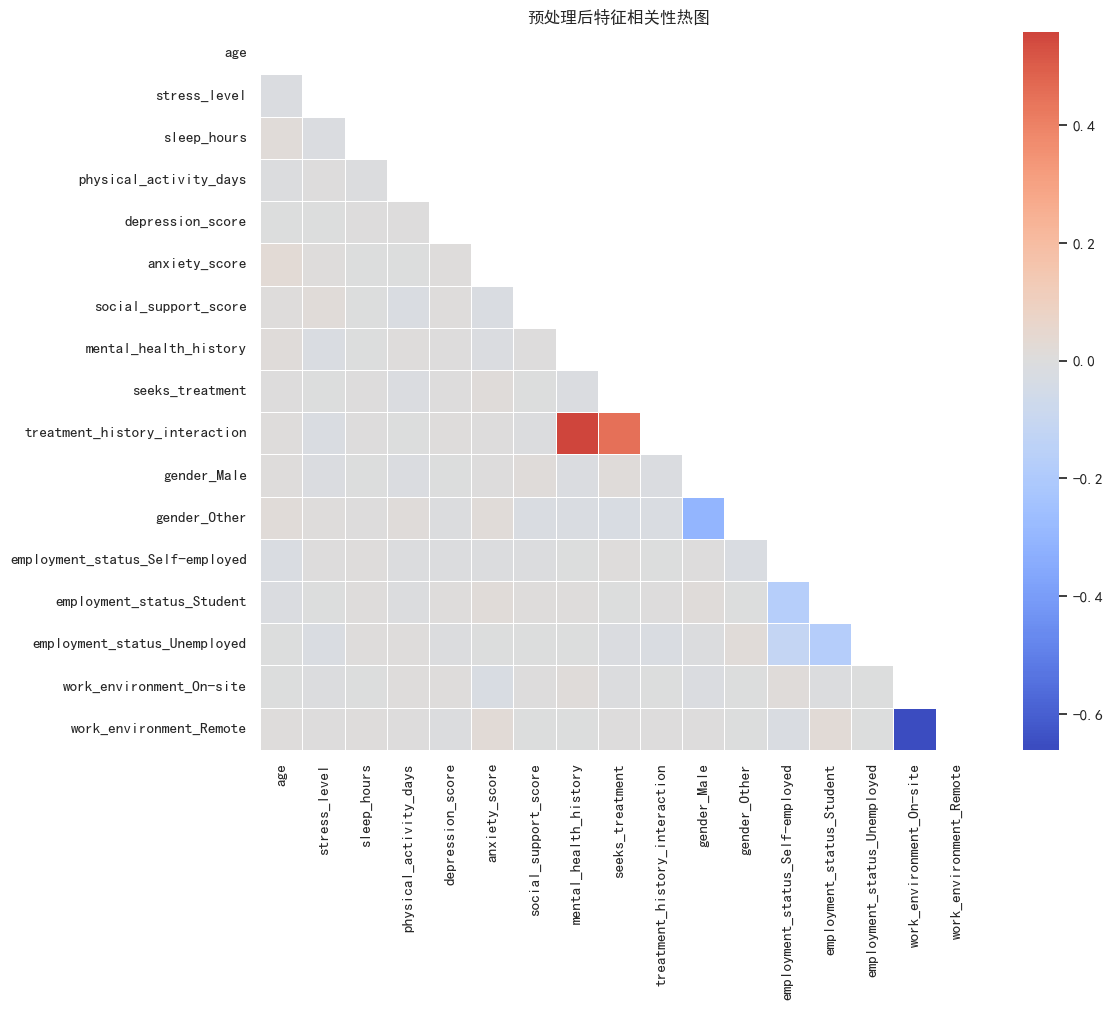

In [12]:
# 9. 保存预处理后的数据和模型
print("\n=== 9. 保存预处理后的数据和编码器 ===")

# 保存处理后的数据集
X_train.to_csv('X_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
pd.DataFrame(y_train, columns=['mental_health_risk']).to_csv('y_train.csv', index=False)
pd.DataFrame(y_test, columns=['mental_health_risk']).to_csv('y_test.csv', index=False)

# 保存编码器和标准化器
joblib.dump(le, 'label_encoder.pkl')
joblib.dump(scaler, 'standard_scaler.pkl')
joblib.dump(scaler_optional, 'optional_scaler.pkl')

print("\n预处理完成，数据已保存为CSV文件")

# 10. 预处理结果总结
print("\n=== 10. 预处理结果总结 ===")
print(f"1. 原始数据样本数: {df.shape[0]}, 特征数: {df.shape[1]}")
print(f"2. 处理后特征数: {features.shape[1]}")
print(f"3. 移除的特征: productivity_score（与depression_score高度相关）")
print(f"4. 合并的类别: 'Non-binary'和'Prefer not to say'被合并为'Other'")
print(f"5. 添加的交互特征: mental_health_history × seeks_treatment")
print(f"6. 标准化的变量: {std_cols + optional_std_cols}")
print(f"7. 训练集样本数: {X_train.shape[0]}")
print(f"8. 测试集样本数: {X_test.shape[0]}")

# 可视化特征相关性（处理后）
plt.figure(figsize=(12, 10))
corr_matrix = X_train.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, annot=False, fmt='.2f')
# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.title('预处理后特征相关性热图')
plt.tight_layout()
plt.savefig('processed_features_correlation.png', dpi=300)
plt.show()

